In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [174]:
df = pd.read_csv("data/train.csv") 
df_test = pd.read_csv("data/Track 1/test.csv") 

# Добавляем total_seconds
df['total_seconds'] = df.epoch.map(lambda x: (datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%f')-datetime(2014,1,1)).total_seconds())

df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,total_seconds
0,0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0.000
1,1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,2803.000
2,2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,5606.001
3,3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,8409.001
4,4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,11212.002


Описание полей датасета:
- id - integer measurement id
- epoch — datetime in "%Y-%m-%dT%H:%M:%S.%f” format (like 2014-02-01T00:44:57.685)
- sat_id — integer satellite id
- (x, y, z), (x_sim, y_sim, z_sim)	реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) координаты спутника (км)
- реальные (полученные с помощью точного симулятора) и смоделированные (полученные с помощью симулятора SGP4) скорости спутника (км / с)

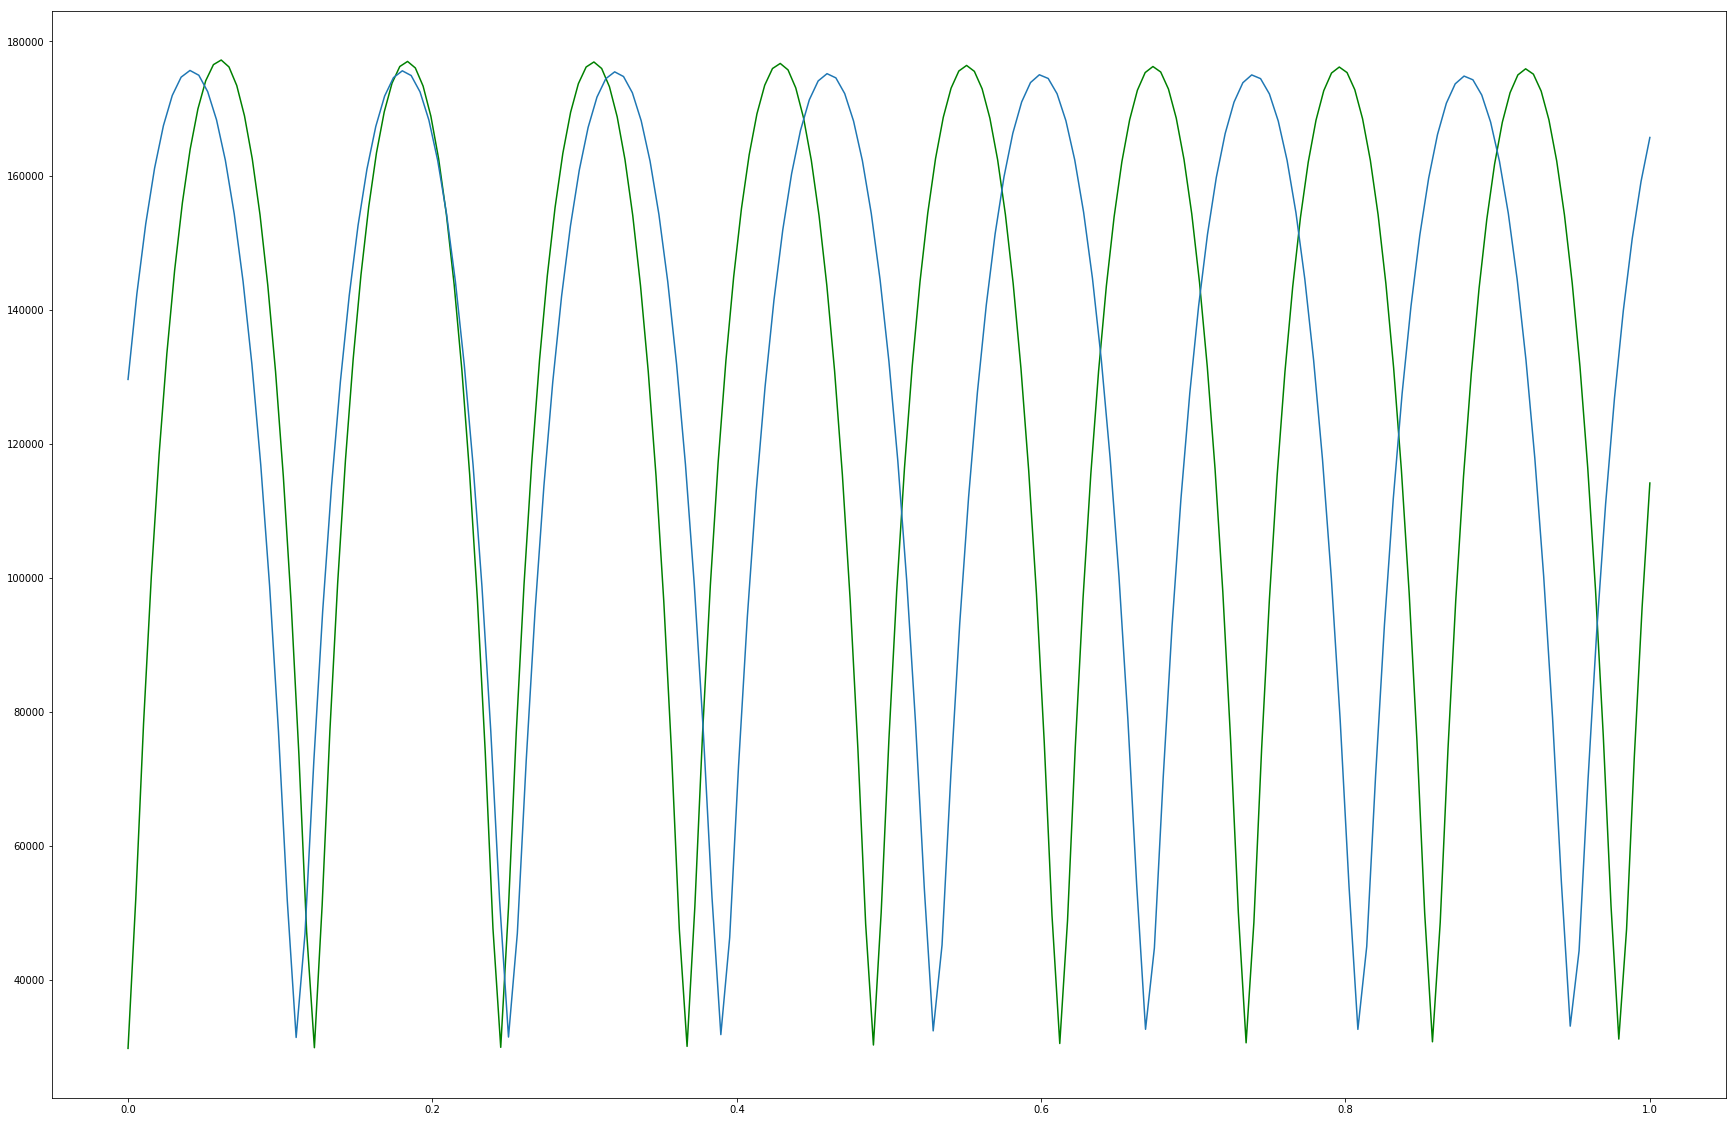

In [138]:
index = 20

plt.figure(figsize = (30, 20))
sat = df[df.sat_id==index]

x = np.linspace(0.0, 1.0, num=len(sat))

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y,'g')

sat = df_test[df_test.sat_id==index]
x = np.linspace(0.0, 1.0, num=len(sat))

y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y)

plt.show()

In [140]:
df['error'] = ((df.x-df.x_sim)**2+(df.y-df.y_sim)**2+(df.z-df.z_sim)**2)**0.5
df['error']

0           27.474289
1           38.388178
2           48.170688
3           55.669776
4           60.700181
             ...     
649907    2415.202660
649908    2532.508684
649909    2674.953236
649910    2840.340584
649911    3022.749134
Name: error, Length: 649912, dtype: float64

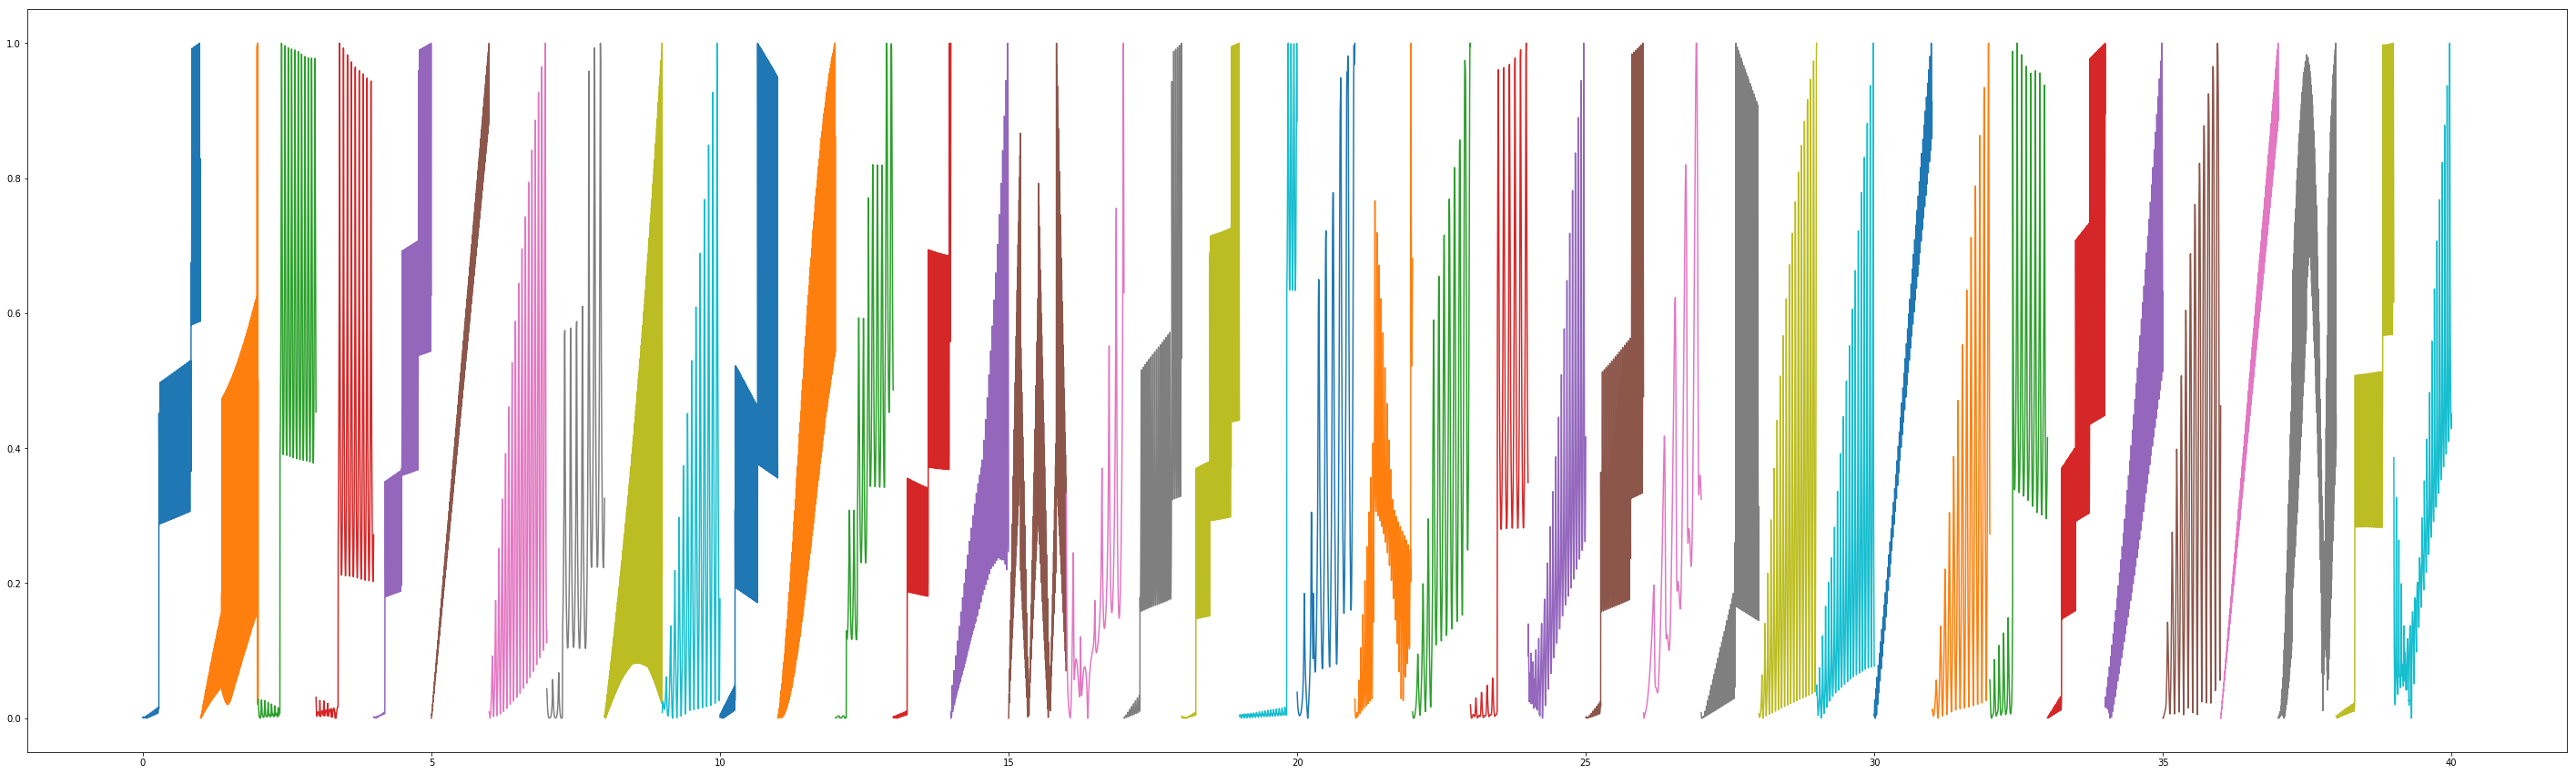

In [143]:
plt.figure(figsize = (50, 15))

for i in range(40):
    n = len(df[df['sat_id']==i])
    
    x = np.linspace(1.0 * i, 1.0 * (i+1), num=n)
    
    y = df[df['sat_id']==i]['error']
    y=y-y.min()
    y=y/y.max()
    
    plt.plot(x,y)
plt.show()

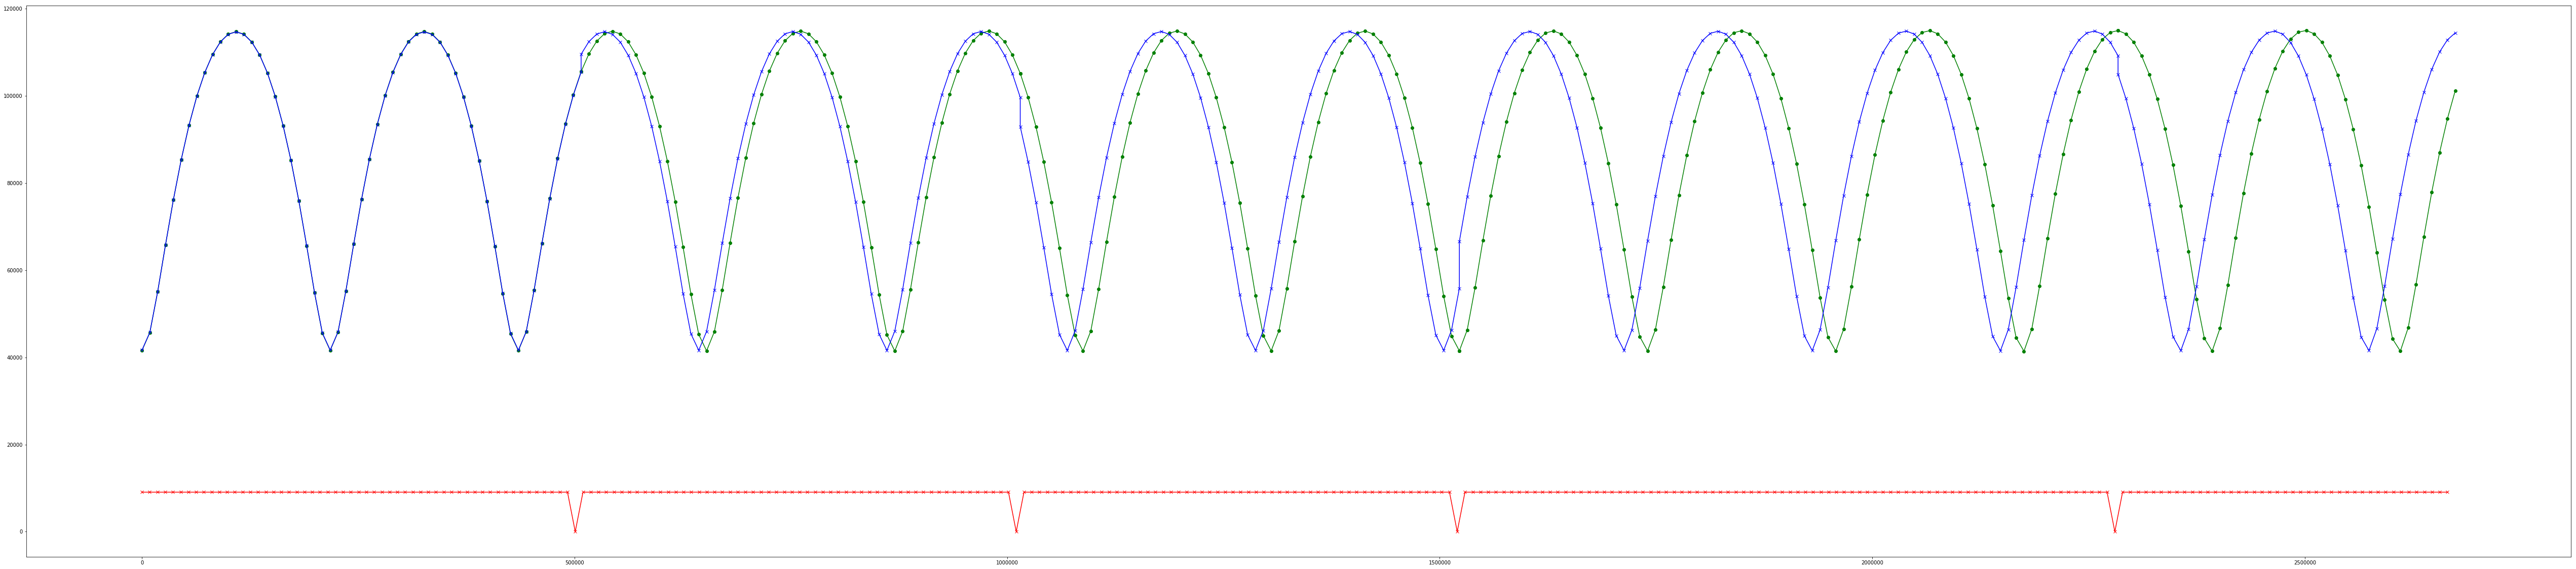

In [201]:
plt.figure(figsize = (90, 20))
sat = df[df.sat_id==12]

#x = np.linspace(0.0, 1.0, num=len(sat))
x = sat['total_seconds']

y=(sat.x**2 + sat.y**2 + sat.z**2)**0.5
plt.plot(x,y, '-go')

x = sat['total_seconds']
y=(sat.x_sim**2 + sat.y_sim**2 + sat.z_sim**2)**0.5
plt.plot(x,y, '-bx')

x = np.linspace(0.0, sat['total_seconds'].max(), num=len(sat))


plt.plot(x, sat['total_seconds'].diff().shift(-1), '-rx')

plt.show()